In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torchtext
from torchtext.data import get_tokenizer
import spacy
from torch.nn.utils.rnn import pad_sequence
from collections import Counter
from torchtext.vocab import vocab as build_vocab
from torch.utils.data import DataLoader, TensorDataset
import sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from transformers import AutoTokenizer, AutoModelForSequenceClassification

In [24]:
df = pd.read_csv('courses.csv')
df.head()

,Course,ID,Department
0,Principles of Nutrition,BIOL,Biology
1,Nutrition for Fitness and Physical Activity,BIOL,Biology
2,Introduction to Human Physiology,BIOL,Biology
3,Biotechnology Management,BIOL,Biology
4,Living Biology at Brown and Beyond,BIOL,Biology


In [25]:
text = df['Course']
labels_text = df['Department']

In [26]:
text_list = text.tolist()
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
encoded = tokenizer(text_list, padding=True, return_tensors='np')
sequences = encoded['input_ids']
print(sequences.shape)
max_length = sequences.shape[1]

(6690, 26)


In [27]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels_text)
output_dim = len(label_encoder.classes_)

In [28]:
X_train, X_test, y_train, y_test = train_test_split(sequences, labels_encoded, test_size=0.2, random_state=17)
train_data = TensorDataset(torch.tensor(X_train), torch.tensor(y_train))
test_data = TensorDataset(torch.tensor(X_test), torch.tensor(y_test))
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
test_loader = DataLoader(test_data, batch_size=32, shuffle=False)

In [65]:
model = AutoModelForSequenceClassification.from_pretrained("distilbert-base-uncased", num_labels=output_dim)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [66]:
for param in model.distilbert.parameters():
    param.requires_grad = False

In [67]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=5e-3)

In [68]:
def train_loop(model, train_loader, val_loader, loss_fn, optimizer, num_epochs=100):
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(num_epochs):
        model.train()
        total_loss, correct, total = 0, 0, 0        

        for inputs, targets in train_loader:
            
            optimizer.zero_grad()
            outputs = model(inputs).logits
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()

            total_loss += loss.item() * targets.size(0)
            correct += (outputs.argmax(1) == targets).sum().item()
            total += targets.size(0)

        train_loss = total_loss / total
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        # Validation
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = model(inputs).logits
                loss = loss_fn(outputs, targets)

                val_loss += loss.item() * targets.size(0)
                val_correct += (outputs.argmax(1) == targets).sum().item()
                val_total += targets.size(0)

        val_loss /= val_total
        val_acc = val_correct / val_total
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)

        print(f"Epoch {epoch+1}/{num_epochs}: "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    return history

In [69]:
history = train_loop(model, train_loader, test_loader, loss_fn, optimizer, 60)
torch.save(model.state_dict(), "finetune_bert_torch.pth")

Epoch 1/60: Train Loss: 3.4346, Train Acc: 0.1390 | Val Loss: 2.9627, Val Acc: 0.1951
Epoch 2/60: Train Loss: 2.9277, Train Acc: 0.2231 | Val Loss: 2.6379, Val Acc: 0.2855
Epoch 3/60: Train Loss: 2.7508, Train Acc: 0.2672 | Val Loss: 2.4819, Val Acc: 0.3259
Epoch 4/60: Train Loss: 2.5931, Train Acc: 0.2982 | Val Loss: 2.4207, Val Acc: 0.3333
Epoch 5/60: Train Loss: 2.5019, Train Acc: 0.3227 | Val Loss: 2.3235, Val Acc: 0.3625
Epoch 6/60: Train Loss: 2.4419, Train Acc: 0.3307 | Val Loss: 2.2900, Val Acc: 0.3610
Epoch 7/60: Train Loss: 2.3865, Train Acc: 0.3436 | Val Loss: 2.3017, Val Acc: 0.3528
Epoch 8/60: Train Loss: 2.3640, Train Acc: 0.3412 | Val Loss: 2.1780, Val Acc: 0.3916
Epoch 9/60: Train Loss: 2.3039, Train Acc: 0.3612 | Val Loss: 2.1490, Val Acc: 0.3976
Epoch 10/60: Train Loss: 2.2857, Train Acc: 0.3657 | Val Loss: 2.1466, Val Acc: 0.4021
Epoch 11/60: Train Loss: 2.2414, Train Acc: 0.3772 | Val Loss: 2.0728, Val Acc: 0.4230
Epoch 12/60: Train Loss: 2.2412, Train Acc: 0.3743 |

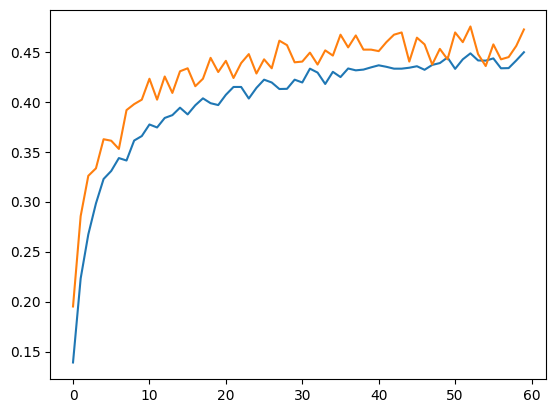

In [81]:
plt.plot(history['train_acc'], label='accuracy')
plt.plot(history['val_acc'], label='val_accuracy')

In [107]:
predict_text = "Imperial Republicanism in Antiquity"
tokens = tokenizer(predict_text, return_tensors="pt")
sequence = tokens['input_ids']
with torch.no_grad():
    model.eval()
    output = model(sequence)
    logits = output.logits
    probabilities = torch.nn.functional.softmax(logits, dim=1)

    top_probs, top_indices = torch.topk(probabilities, k=5)
    top_probs = top_probs.squeeze().tolist()
    top_indices = top_indices.squeeze().tolist()

    print(f"Top 5 predicted departments for '{predict_text}':")
    for i, (prob, idx) in enumerate(zip(top_probs, top_indices)):
        department = label_encoder.inverse_transform([idx])[0]
        print(f"{i+1}. {department}: {prob*100:.2f}%")

Top 5 predicted departments for 'Imperial Republicanism in Antiquity':
1. Classics: 53.67%
2. History: 39.73%
3. Political Science: 2.66%
4. Philosophy: 1.68%
5. Archaeology: 0.68%
